# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- scipy: https://scipy.org/install/
- gym: https://github.com/openai/gym 

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

# Implementation of the Windy GridWorld environment in Example 6.5

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""Windy GridWorld Env"""
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """
        Args:
            enable_king_move (bool): If True, using King's movement. Otherwise, using the original action space.
            enable_no_move (bool): If True, adding no movement under the condition of enable_king_move = True.
        
        Note: for different setup, we have the following action spaces:
            - Original: ["up", "down", "left", "right"];
            - King's move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right"];
            - King's move + no move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right", "stay"]
        """
        
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        if enable_king_move:
            # add King's move actions
            if enable_no_move:
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1]),  # add down-left
                    "stay": np.array([0, 0])  # add no move action
                }
            else:
                # add King's move actions + one no movement action
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1])  # add down-left
                }
        else:
            # normal actions
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }

        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        """
        Args:
            act (string): a string variable indicating the action.
        """
        # obtain the state array
        s_arr = np.array(self.state)

        # obtain the action array
        act_arr = self.action_space[act.lower()]

        # obtain the wind array
        wind_arr = -1 * np.array([self.wind[self.state[1]], 0], dtype=int)

        # compute the next state
        next_s_arr = np.clip(s_arr + act_arr + wind_arr,
                             a_min=np.array([0, 0]),
                             a_max=np.array([self.grid.shape[0]-1, self.grid.shape[1]-1]))

        # compute the reward
        reward = 0 if next_s_arr.tolist() == self.goal_state else -1

        # check the termination
        terminated = True if reward == 0 else False

        # update the tracking variables
        self.state = next_s_arr.tolist()
        self.t += 1
        self.act = act

        return self.state, reward, terminated

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)

In [3]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)
    plt.show()

# Test Windy GridWorld 

In [4]:
# check whether enable King's movement and no movement
use_king_move = False
use_no_move = False

# create the environment
env = WindyGridWorld(enable_king_move=use_king_move,
                     enable_no_move=use_no_move)
s, d = env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    a = np.random.choice(list(env.action_space.keys()), 1)[0]
    
    # interact with the envrionment
    next_s, r, d = env.step(a)
    
    # print info
    print(f"t = {t}: state = {s}, action = {a},  reward = {r}, next_state = {next_s}, done = {d}")
    s = next_s
    
    # check termination
    if d:
        s, d = env.reset()

t = 0: state = [3, 0], action = right,  reward = -1, next_state = [3, 1], done = False
t = 1: state = [3, 1], action = right,  reward = -1, next_state = [3, 2], done = False
t = 2: state = [3, 2], action = left,  reward = -1, next_state = [3, 1], done = False
t = 3: state = [3, 1], action = right,  reward = -1, next_state = [3, 2], done = False
t = 4: state = [3, 2], action = right,  reward = -1, next_state = [3, 3], done = False
t = 5: state = [3, 3], action = left,  reward = -1, next_state = [2, 2], done = False
t = 6: state = [2, 2], action = down,  reward = -1, next_state = [3, 2], done = False
t = 7: state = [3, 2], action = up,  reward = -1, next_state = [2, 2], done = False
t = 8: state = [2, 2], action = left,  reward = -1, next_state = [2, 1], done = False
t = 9: state = [2, 1], action = up,  reward = -1, next_state = [1, 1], done = False


# Q4 - (a): Solve the Windy Gridworld using the following algorithms and reproduce the figure similar to the figure in Example 6.5

- Implement the SARSA, Expected SARSA, and Q learning.
- Reproduce the plot in the Example 6.5 and plot the three curves in a single plot. You can use the provided plotting code.

In [5]:
""" CODE HERE YOUR IMPLEMENTATION for SARSA """

def epsilon_soft(env, state, q_values, actions_list, epsilon):
    '''
    Select action according to the epsilon soft algorithm
    '''
    # Find the corresponding index in the q_values array
    state_index = env.state_space.index(state)
    # Find current Qs for the specific state
    Qs = q_values[state_index]
    # Apply epsilon_soft to choose action
    if random.random() < epsilon:
        action = random.choice(actions_list)
    else:
        # Get the indices of all best actions of given state 
        indices = np.where(np.array(Qs) == max(Qs))[0].tolist()
        # Breaking ties randomly
        action = actions_list[random.choice(indices)]
    return action

def retrieve_Q_value(env, q_values, state, actions_list, action):
    '''
    Get Q value of given state-action pair
    '''
    state_index = env.state_space.index(state)
    action_index = actions_list.index(action)
    return q_values[state_index][action_index], state_index, action_index

def update_Q_value(Q_state, reward, Q_next_state, alpha, gamma):
    '''
    Update Q value of state-action pair with TD(0) method
    '''
    TD_error = reward + gamma * Q_next_state - Q_state
    return Q_state + alpha * TD_error
    
def run_SARSA(alpha = 0.5, epsilon = 0.1, gamma = 0.95, 
              run_num = 10, time_step = 8000, use_king_move = False, use_no_move = False):
    '''
    Implement SARSA (on-policy TD control) for estimating Q
    '''
    # Create the environment
    env = WindyGridWorld(enable_king_move=use_king_move,
                         enable_no_move=use_no_move)
    # Create empty array to record running results
    actions_list = list(env.action_space.keys())
    steps_episodes = np.empty((run_num, time_step+1))
    # Start the loop
    state, done = env.reset()
    for r in range(run_num):
        # Initialize the Q values
        q_values = np.zeros((len(env.state_space), len(env.action_space)), dtype=float)
        t, episodes_num = 0, 0
        steps_episodes[r, t] = episodes_num
        while t < time_step:
            action = epsilon_soft(env, state, q_values, actions_list, epsilon)
            next_state, reward, done = env.step(action)
            t += 1
            steps_episodes[r, t] = episodes_num
            while state != env.goal_state and t < time_step:
                next_action = epsilon_soft(env, next_state, q_values, actions_list, epsilon)
                # Retrieve the Q value of corresponding state-action pairs
                Q_state, state_index, action_index = retrieve_Q_value(env, q_values, state,
                                                                      actions_list, action)
                Q_next_state = retrieve_Q_value(env, q_values, next_state, actions_list, 
                                                next_action)[0]
                # Conduct TD(0) update
                q_values[state_index, action_index] = update_Q_value(Q_state, reward, Q_next_state, 
                                                                     alpha, gamma)
                state = next_state                
                action = next_action
                next_state, reward, done = env.step(action)
                t += 1
                steps_episodes[r, t] = episodes_num
            episodes_num += 1
            state, done = env.reset()
    return steps_episodes, q_values, actions_list

In [6]:
""" CODE HERE YOUR IMPLEMENTATION for Expected SARSA """

def update_Q_Expected(q_values, Q_state, reward, next_state, epsilon, alpha, gamma):
    '''
    Update Q value of state-action pair with Expected SARSA method
    '''
    # Get current Q values of the next state
    next_state_index = env.state_space.index(next_state)
    Qs_next_state = q_values[next_state_index]
    # Calculate the expected Q value of the next state
    # Calculate the epsilon case
    avg_epsilon = np.average(Qs_next_state) * epsilon
    # Calculate the non_epsilon case
    avg_non_epsilon = max(Qs_next_state) * (1-epsilon)
    avg_Q_next_state = avg_epsilon + avg_non_epsilon
    # Update Q value of current state
    TD_error = reward + gamma * avg_Q_next_state - Q_state
    return Q_state + alpha * TD_error

def run_Expected_SARSA(alpha = 0.5, epsilon = 0.1, gamma = 0.95,
                       run_num = 10, time_step = 8000, use_king_move = False, use_no_move = False):
    '''
    Implement Expected SARSA (TD control) for estimating Q
    '''
    # Create the environment
    env = WindyGridWorld(enable_king_move=use_king_move,
                         enable_no_move=use_no_move)
    # Create empty array to record running results
    actions_list = list(env.action_space.keys())
    steps_episodes = np.empty((run_num, time_step+1))
    # Start the loop
    state, done = env.reset()
    for r in range(run_num):
        # Initialize the Q values
        q_values = np.zeros((len(env.state_space), len(env.action_space)), dtype=float)
        t, episodes_num = 0, 0
        steps_episodes[r, t] = episodes_num
        while t < time_step:
            while state != env.goal_state and t < time_step:
                action = epsilon_soft(env, state, q_values, actions_list, epsilon)
                next_state, reward, done = env.step(action)
                t += 1
                steps_episodes[r, t] = episodes_num
                # Retrieve the Q value of corresponding state-action pairs
                Q_state, state_index, action_index = retrieve_Q_value(env, q_values, state,
                                                                      actions_list, action)
                # Conduct TD(0) update
                q_values[state_index, action_index] = update_Q_Expected(q_values, Q_state, reward,
                                                                        next_state, epsilon,
                                                                        alpha, gamma) 
                state = next_state
            episodes_num += 1
            state, done = env.reset()
    return steps_episodes

In [7]:
""" CODE HERE YOUR IMPLEMENTATION for Q learning """

def update_Q(q_values, Q_state, reward, next_state, alpha, gamma):
    '''
    Update Q value of state-action pair with Q-learning method
    '''
    # Get current Q values of the next state
    next_state_index = env.state_space.index(next_state)
    Qs_next_state = q_values[next_state_index]
    # Calculate the max Q value of the next state
    Q_next_state = max(Qs_next_state)
    # Update Q value of current state
    TD_error = reward + gamma * Q_next_state - Q_state
    return Q_state + alpha * TD_error

def run_Q_learning(alpha = 0.5, epsilon = 0.1, gamma = 0.95,
                   run_num = 10, time_step = 8000, use_king_move = False, use_no_move = False):
    '''
    Implement Q-learning (off-policy TD control) for estimating Q
    '''
    # Create the environment
    env = WindyGridWorld(enable_king_move=use_king_move,
                         enable_no_move=use_no_move)
    # Create empty array to record running results
    actions_list = list(env.action_space.keys())
    steps_episodes = np.empty((run_num, time_step+1))
    # Start the loop
    state, done = env.reset()
    for r in range(run_num):
        # Initialize the Q values
        q_values = np.zeros((len(env.state_space), len(env.action_space)), dtype=float)
        t, episodes_num = 0, 0
        steps_episodes[r, t] = episodes_num
        while t < time_step:
            while state != env.goal_state and t < time_step:
                action = epsilon_soft(env, state, q_values, actions_list, epsilon)
                next_state, reward, done = env.step(action)
                t += 1
                steps_episodes[r, t] = episodes_num
                # Retrieve the Q value of corresponding state-action pairs
                Q_state, state_index, action_index = retrieve_Q_value(env, q_values, state,
                                                                      actions_list, action)
                # Conduct TD(0) update
                q_values[state_index, action_index] = update_Q(q_values, Q_state, reward, next_state, 
                                                               alpha, gamma) 
                state = next_state
            episodes_num += 1
            state, done = env.reset()
    return steps_episodes

<Figure size 640x480 with 0 Axes>

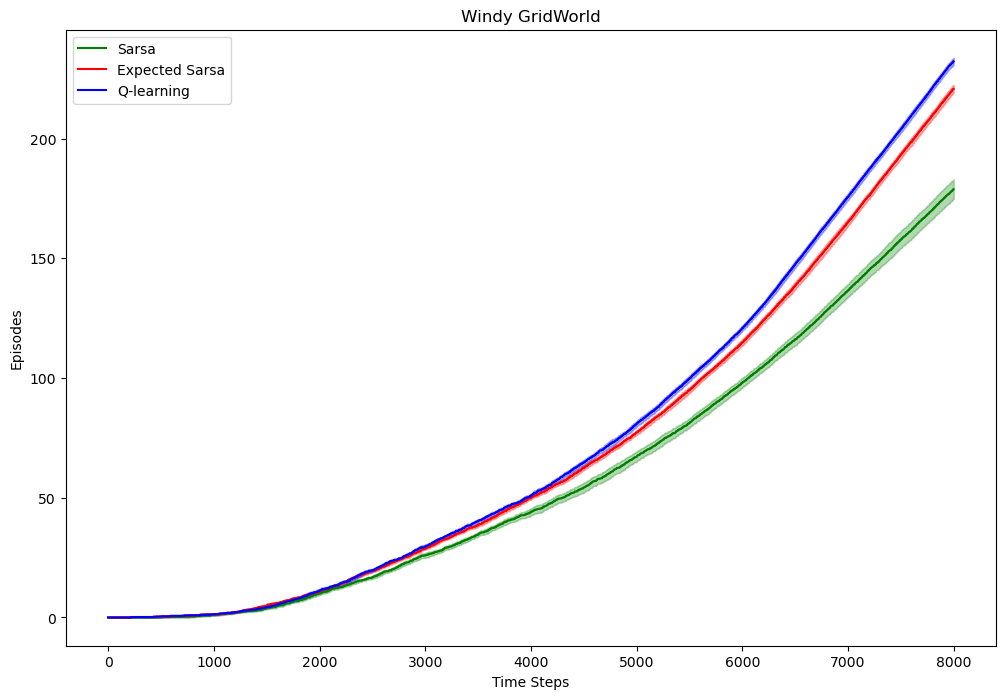

In [8]:
""" CODE HERE YOUR IMPLEMENTATION OF FIGURE PLOTTING """

steps_episodes_0 = run_SARSA()[0]
steps_episodes_1 = run_Expected_SARSA()
steps_episodes_2 = run_Q_learning()

plot_curves([steps_episodes_0, steps_episodes_1, steps_episodes_2], 
            ["Sarsa", "Expected Sarsa", "Q-learning"],
            ["g", "r", "b"],
            "Episodes",
            "Windy GridWorld")

# Q4 - (b): Re-solve the Windy GridWorld with Kings' movement and No movement.

<Figure size 640x480 with 0 Axes>

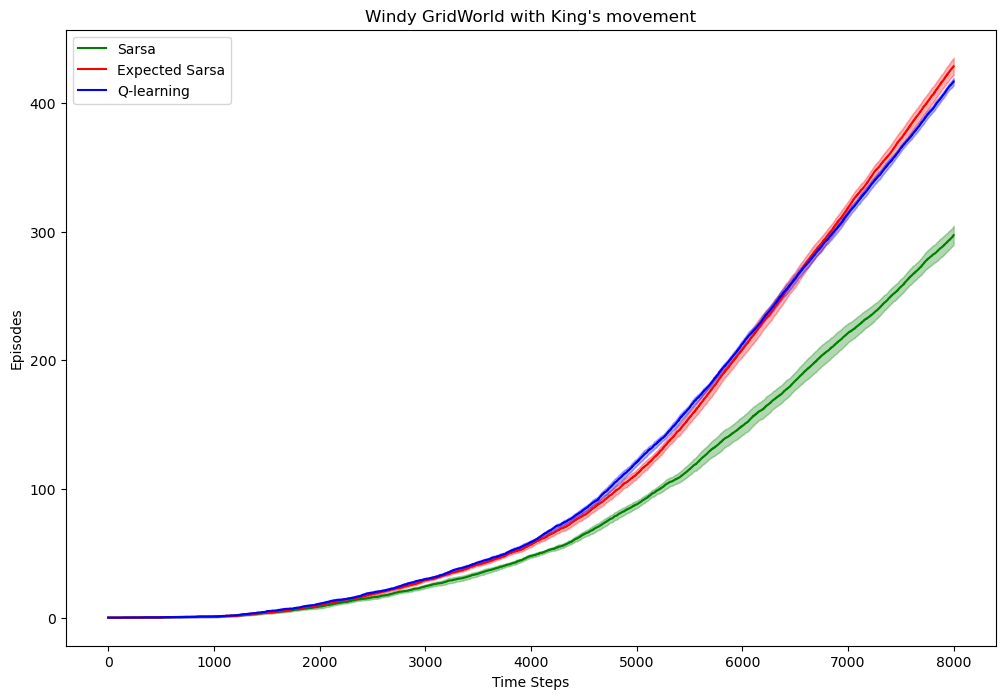

In [9]:
""" Reproduce the Figure above in Windy GridWorld with King's movement """
""" CODE HERE YOUR IMPLEMENTATION OF FIGURE PLOTTING """

steps_episodes_3 = run_SARSA(use_king_move=True)[0]
steps_episodes_4 = run_Expected_SARSA(use_king_move=True)
steps_episodes_5 = run_Q_learning(use_king_move=True)

plot_curves([steps_episodes_3, steps_episodes_4, steps_episodes_5], 
            ["Sarsa", "Expected Sarsa", "Q-learning"],
            ["g", "r", "b"],
            "Episodes", 
            "Windy GridWorld with King's movement")

<Figure size 640x480 with 0 Axes>

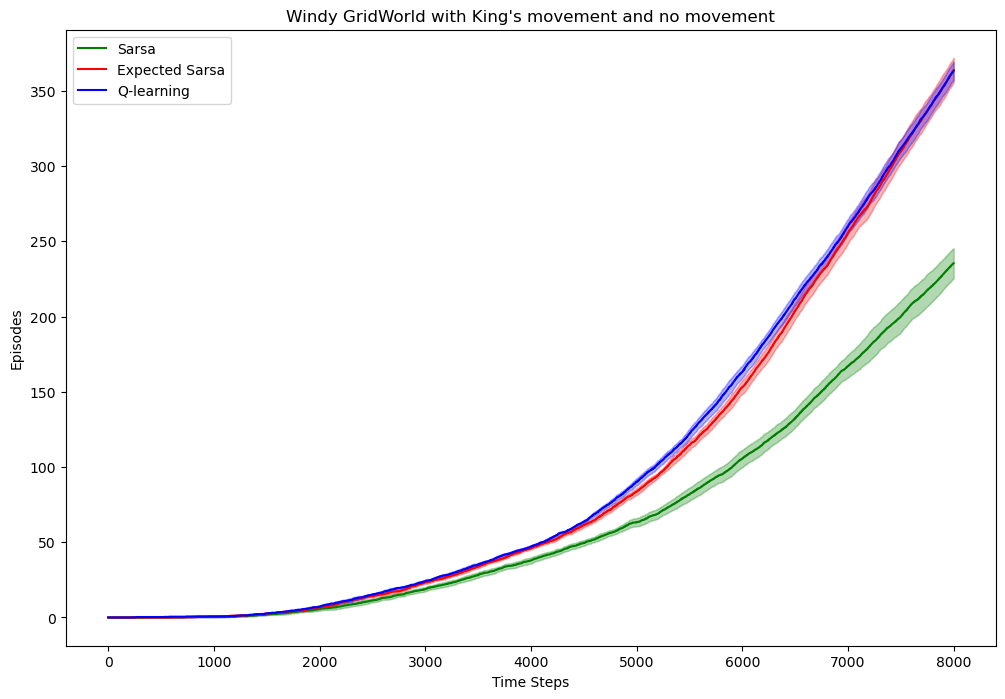

In [10]:
""" Reproduce the Figure above in Windy GridWorld with King's movement + no movement """

steps_episodes_6 = run_SARSA(use_king_move=True, use_no_move=True)[0]
steps_episodes_7 = run_Expected_SARSA(use_king_move=True, use_no_move=True)
steps_episodes_8 = run_Q_learning(use_king_move=True, use_no_move=True)

plot_curves([steps_episodes_6, steps_episodes_7, steps_episodes_8], 
            ["Sarsa", "Expected Sarsa", "Q-learning"],
            ["g", "r", "b"],
            "Episodes", 
            "Windy GridWorld with King's movement and no movement")

# Q5: Bias-variance trade-off

In [11]:
""" Please code your implementation of running the experiments here """

# Step 1 - Generating "training" sets

# Get the Q-table from the near-optimal stochastic policy found by SARSA
Q_table, actions_list = run_SARSA()[1:]

# Generate episodes based on the Q-table and an epsilon greedy policy
def generate_episodes(Q_table, actions_list, run_num, epsilon = 0.1):
    '''
    Generate episodes according to a near-optimal stochastic policy
    '''
    episodes_list = list()
    for i in range(run_num):
        # Create an empty list to store an episode
        episode_list = list()
        # Create the environment
        env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
        state, done = env.reset()
        # Keep running until enter the terminal state
        while not done:
            action = epsilon_soft(env, state, Q_table, actions_list, epsilon)
            episode_list.append((state, action))
            next_state, reward, done = env.step(action)
            state = next_state
        # Append the single episode to the episodes list
        episodes_list.append(episode_list)
    return episodes_list 

In [12]:
episodes_list_1 = generate_episodes(Q_table, actions_list, 1, epsilon = 0.1)
episodes_list_10 = generate_episodes(Q_table, actions_list, 10, epsilon = 0.1)
episodes_list_50 = generate_episodes(Q_table, actions_list, 50, epsilon = 0.1)

In [13]:
# Step 2 - TD(0) prediction and MC prediction

# First-visit MC prediction

def MC_prediction(episodes_list, gamma = 1):
    '''
    Apply first-visit MC prediction to estimate V
    '''
    # Create the state values table
    env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
    states_list = env.state_space
    state_values = [0.0 for each in states_list]
    encounter_nums= [0 for each in states_list]
    # Start MC prediction
    for episode in episodes_list:
        returns = [-1] * (len(episode)-1) + [0]
        states = [each[0] for each in episode]
        G = 0
        for i in range(len(episode)-1, -1, -1):
            G = gamma * G + returns[i]
            if states[i] not in states[:i]:
                # Get state's index
                state_index = states_list.index(states[i])
                encounter_num = encounter_nums[state_index]
                state_value = state_values[state_index]
                # Update state's value
                updated_value = state_value + (G-state_value)/(encounter_num+1)
                state_values[state_index] = updated_value
                encounter_nums[state_index] += 1
    return state_values
        
def TD_prediction(episodes_list, alpha = 0.5, gamma = 1):
    '''
    Apply TD(0) prediction to estimate V
    '''
    # Create the state values table
    env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
    states_list = env.state_space
    state_values = [0.0 for each in states_list]
    # Start TD(0) prediction
    for episode in episodes_list:
        returns = [-1] * (len(episode)-1) + [0]
        states = [each[0] for each in episode]
        for i in range(len(episode)-1):
            # Get state's index and value
            state_i = states_list.index(states[i])
            next_state_i = states_list.index(states[i+1])
            state_v = state_values[state_i]
            next_state_v = state_values[next_state_i]
            # Update state's value
            TD_error = returns[i] + gamma*next_state_v - state_v
            state_values[state_i] += alpha * TD_error
        # Update the state's value before terminal state
        state_i = states_list.index(states[-1])
        state_v = state_values[state_i]
        TD_error = returns[-1] + gamma*0 - state_v
        state_values[state_i] += alpha * TD_error
    return state_values

In [14]:
state_values_MC_1 = MC_prediction(episodes_list_1, gamma=1)
state_values_MC_10 = MC_prediction(episodes_list_10, gamma=1)
state_values_MC_50 = MC_prediction(episodes_list_50, gamma=1)
state_values_TD_1 = TD_prediction(episodes_list_1, alpha=0.5, gamma=1)
state_values_TD_10 = TD_prediction(episodes_list_10, alpha=0.5, gamma=1)
state_values_TD_50 = TD_prediction(episodes_list_50, alpha=0.5, gamma=1)

In [15]:
# Step 3 - Evaluate TD(0) prediction and MC prediction methods

# Generate another 1000 episodes for evaluation
episodes_list_1000 = generate_episodes(Q_table, actions_list, 1000, epsilon = 0.1)

# Collect targets from the MC prediction on the initial state
def collect_MC_targets(episodes_list, gamma = 1):
    '''
    Collect targets of the MC method
    '''
    # Create am empty list to store targets
    targets_list = list()
    for episode in episodes_list:
        returns = [-1] * (len(episode)-1) + [0]
        # Expected V of the initial state can computed directly
        T = len(returns)
        if gamma == 1:
            G = 1 - T
        else:
            G = (1-gamma**(T-1)) / (gamma-1)
        targets_list.append(G)
    return targets_list

# Collect targets from the TD prediction on the initial state
def collect_TD_targets(episodes_list, state_values, alpha = 0.5, gamma = 1):
    '''
    Collect targets of the TD method
    '''
    # Create am empty list to store targets
    targets_list = list()
    # Create the state values table
    env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
    states_list = env.state_space
    # Start TD(0) prediction
    for episode in episodes_list:
        returns = [-1] * (len(episode)-1) + [0]
        states = [each[0] for each in episode]
        for i in range(len(episode)-1):
            # Get state's index and value
            state_i = states_list.index(states[i])
            next_state_i = states_list.index(states[i+1])
            state_v = state_values[state_i]
            next_state_v = state_values[next_state_i]
            # Update state's value
            TD_error = returns[i] + gamma*next_state_v - state_v
            state_values[state_i] += alpha * TD_error
            # Record the target of the initial state
            if states[i] == [3, 0]:
                targets_list.append(TD_error + state_v)
        # Update the state's value before terminal state
        state_i = states_list.index(states[-1])
        state_v = state_values[state_i]
        TD_error = returns[-1] + gamma*0 - state_v
        state_values[state_i] += alpha * TD_error
    return targets_list

# Calculate the true state_value of the initial state
steps_episodes, q_values, actions_list = run_SARSA(alpha=0.5, epsilon=0.1, 
                                                   gamma=1, run_num=1, time_step=20000)
# Calculate the true state_value using dynamic programming
env = WindyGridWorld(enable_king_move=False, enable_no_move=False)
state_index = env.state_space.index([3, 0])
Q_values = q_values[state_index]
epsilon = 0.1
true_state_value = max(Q_values)*(1-epsilon) + sum(Q_values)/len(Q_values)*epsilon

In [16]:
""" Please code your implementation of plotting the histogram figure here """
targets_list_MC = collect_MC_targets(episodes_list_1000, gamma=1)
targets_list_TD_1 = collect_TD_targets(episodes_list_1000, state_values_TD_1, gamma=1)
targets_list_TD_10 = collect_TD_targets(episodes_list_1000, state_values_TD_10, gamma=1)
targets_list_TD_50 = collect_TD_targets(episodes_list_1000, state_values_TD_50, gamma=1)

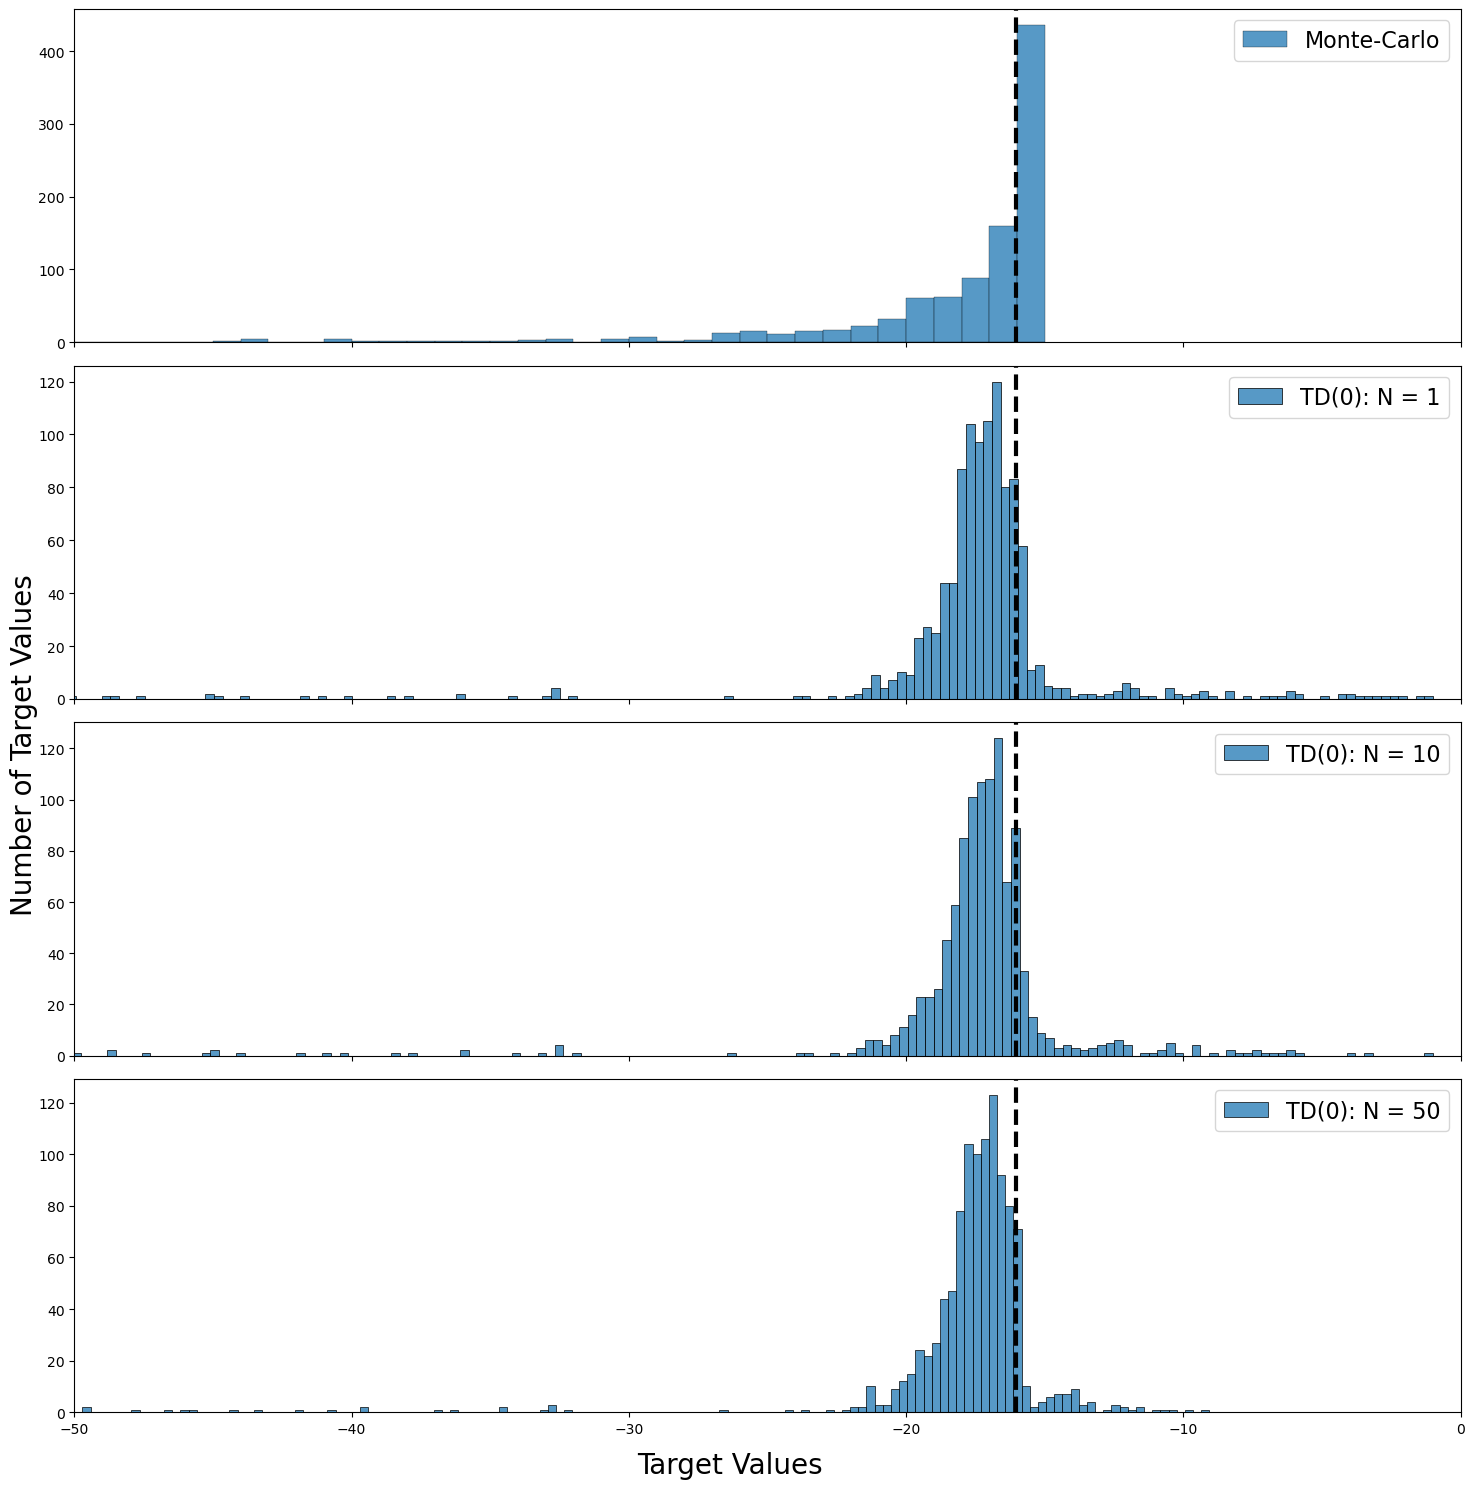

In [18]:
def adjacent_plots(targets_lists, true_state_value, labels):
    '''
    Create subplots that share a common x-axis
    '''
    # The number of plots 
    n_plots = len(targets_lists) 
    # Subplots share a common x-axis
    fig, axs = plt.subplots(n_plots, 1, sharex=True, figsize=(15, 15))
    for i in range(n_plots):
        sns.histplot(data=targets_lists[i], label=labels[i],
                     fill=True, ax=axs[i]).set(xlabel=None, ylabel=None)
        axs[i].axvline(true_state_value, color='k', linestyle='dashed', linewidth=3)
        axs[i].set_xlim(-50,0)
        axs[i].legend(loc="upper right", prop={"size": 16})
    fig.supxlabel("Target Values", fontsize=20)
    fig.supylabel("Number of Target Values", fontsize=20)
    plt.tight_layout()
    plt.show()
    
adjacent_plots([targets_list_MC, targets_list_TD_1, targets_list_TD_10, targets_list_TD_50],
               true_state_value,
               ["Monte-Carlo", "TD(0): N = 1", "TD(0): N = 10", "TD(0): N = 50"])